In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Data Loading

In [2]:
matches = pd.read_csv("matches.csv")
deliveries = pd.read_csv("deliveries.csv")

# Data Cleaning and Standardization

In [3]:
matches.fillna("NA", inplace=True)
deliveries.fillna("NA", inplace=True)

<ipython-input-3-96e39564b527>:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'NA' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  matches.fillna("NA", inplace=True)


In [4]:
def standardize_team_name(team):
    team_dict = {
        "Delhi Daredevils": "Delhi Capitals",
        "Deccan Chargers": "Sunrisers Hyderabad",
        "Royal Challengers Bangalore": "Royal Challengers Bengaluru",
        "Rising Pune Supergiant": "Rising Pune Supergiants",
        "Kings XI Punjab": "Punjab Kings"
    }
    return team_dict.get(team, team)

matches['team1'] = matches['team1'].apply(standardize_team_name)
matches['team2'] = matches['team2'].apply(standardize_team_name)
matches['winner'] = matches['winner'].apply(standardize_team_name)
deliveries['batting_team'] = deliveries['batting_team'].apply(standardize_team_name)
deliveries['bowling_team'] = deliveries['bowling_team'].apply(standardize_team_name)



In [5]:
matches['team1'].unique()

array(['Royal Challengers Bengaluru', 'Punjab Kings', 'Delhi Capitals',
       'Mumbai Indians', 'Kolkata Knight Riders', 'Rajasthan Royals',
       'Sunrisers Hyderabad', 'Chennai Super Kings',
       'Kochi Tuskers Kerala', 'Pune Warriors', 'Gujarat Lions',
       'Rising Pune Supergiants', 'Lucknow Super Giants',
       'Gujarat Titans'], dtype=object)

In [6]:
matches['season'].unique()

array(['2007/08', '2009', '2009/10', '2011', '2012', '2013', '2014',
       '2015', '2016', '2017', '2018', '2019', '2020/21', '2021', '2022',
       '2023', '2024'], dtype=object)

In [7]:
def standardize_season(season):
    season_dict = {
        "2007/08": "2008",
        "2009/10": "2010",
        "2020/21": "2020"
    }
    return season_dict.get(season, season)

matches['season'] = matches['season'].apply(standardize_season)

In [8]:
matches.dtypes

,0
id,int64
season,object
city,object
date,object
match_type,object
player_of_match,object
venue,object
team1,object
team2,object
toss_winner,object


In [9]:
matches['target_overs'] = pd.to_numeric(matches['target_overs'], errors='coerce')
matches['target_runs'] = pd.to_numeric(matches['target_runs'], errors='coerce')
matches['result_margin'] = pd.to_numeric(matches['result_margin'], errors='coerce')

In [10]:
deliveries.dtypes

,0
match_id,int64
inning,int64
batting_team,object
bowling_team,object
over,int64
ball,int64
batter,object
bowler,object
non_striker,object
batsman_runs,int64


# Team Analysis

## Winning Percentage of Teams

<ipython-input-11-81f80ff09d0d>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=winning_percentage.index, y=winning_percentage.values, palette='viridis')


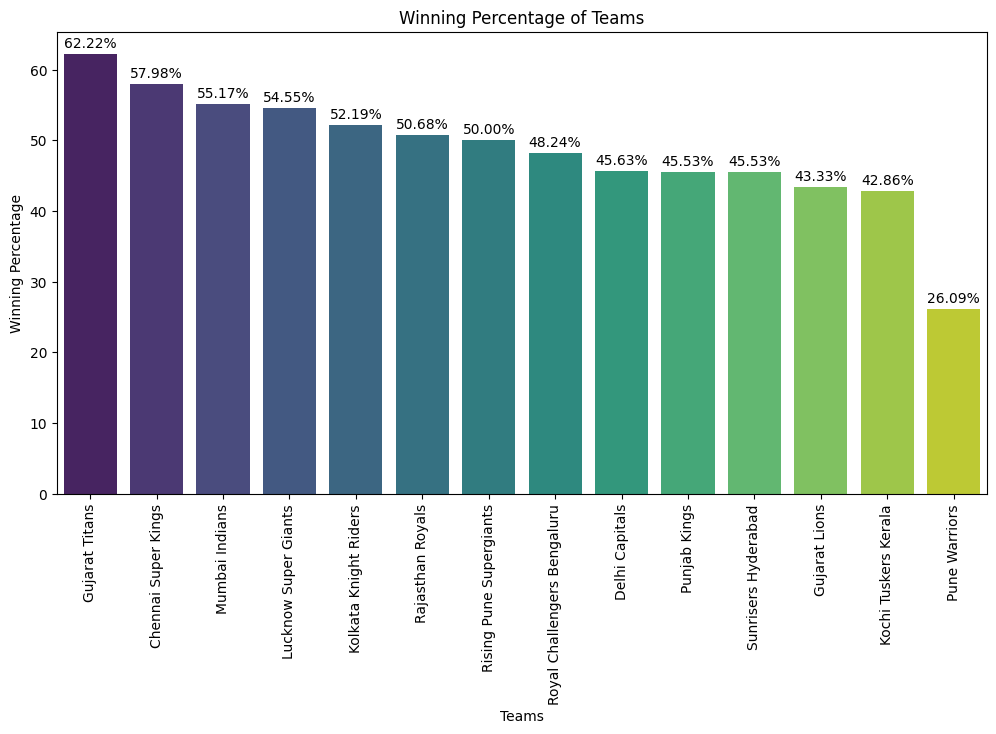

In [11]:
matches_played = matches['team1'].value_counts() + matches['team2'].value_counts()
matches_won = matches['winner'].value_counts()
team_to_remove = 'NA'
matches_won = matches_won[matches_won.index != team_to_remove]
winning_percentage = (matches_won / matches_played * 100).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=winning_percentage.index, y=winning_percentage.values, palette='viridis')
plt.xticks(rotation=90)
plt.xlabel("Teams")
plt.ylabel("Winning Percentage")
plt.title("Winning Percentage of Teams")

for i, v in enumerate(winning_percentage.values):
    plt.text(i, v + 0.5, f"{v:.2f}%", ha='center', va='bottom', fontsize=10)

plt.show()


## Average Run Rate of Each Team and Average Economy Rate of Each Team

<ipython-input-12-56b9f27d6c08>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='batting_team', y='Run Rate', data=team_run_rate, palette='viridis')


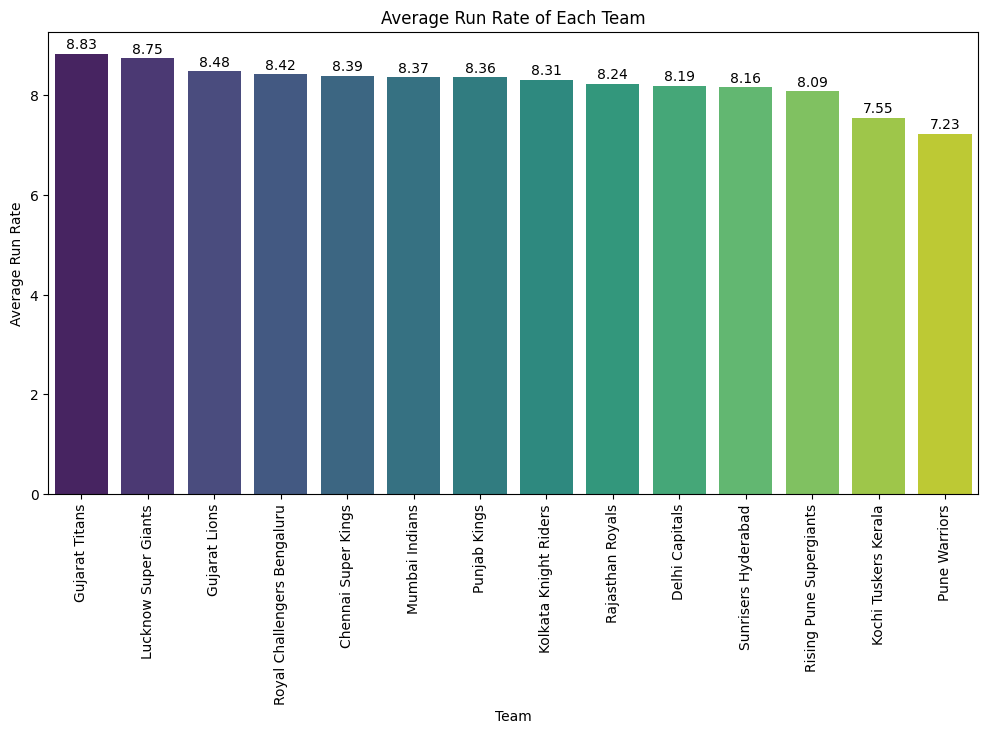

<ipython-input-12-56b9f27d6c08>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='bowling_team', y='Economy Rate', data=team_economy_rate, palette='viridis')


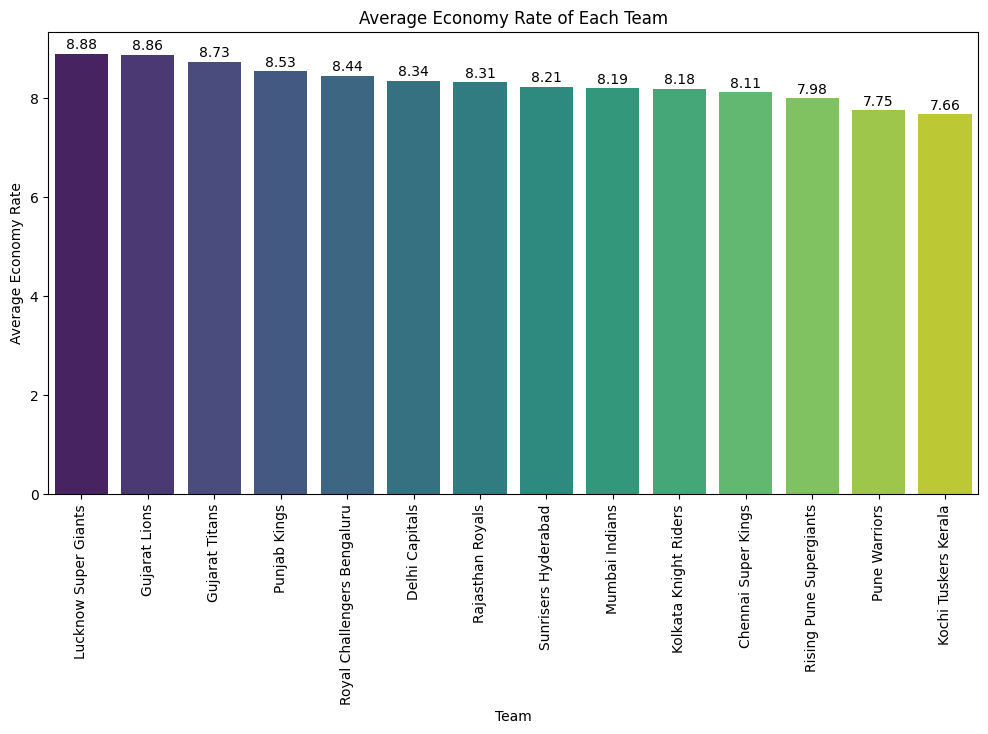

In [12]:
valid_deliveries = deliveries[~deliveries['extras_type'].isin(['wides', 'noballs'])]

team_runs_scored = deliveries.groupby('batting_team')['total_runs'].sum()
team_overs_faced = valid_deliveries.groupby('batting_team').size() / 6  # Convert balls to overs

team_run_rate = (team_runs_scored / team_overs_faced).reset_index(name='Run Rate')
team_run_rate = team_run_rate.sort_values(by='Run Rate', ascending=False)  # Sort by Run Rate

team_runs_conceded = deliveries.groupby('bowling_team')['total_runs'].sum()
team_overs_bowled = valid_deliveries.groupby('bowling_team').size() / 6

team_economy_rate = (team_runs_conceded / team_overs_bowled).reset_index(name='Economy Rate')
team_economy_rate = team_economy_rate.sort_values(by='Economy Rate', ascending=False)  # Sort by Economy Rate

plt.figure(figsize=(12, 6))
sns.barplot(x='batting_team', y='Run Rate', data=team_run_rate, palette='viridis')
plt.xticks(rotation=90)
plt.xlabel("Team")
plt.ylabel("Average Run Rate")
plt.title("Average Run Rate of Each Team")
for i, v in enumerate(team_run_rate['Run Rate']):
    plt.text(i, v + 0.1, f"{v:.2f}", ha='center', fontsize=10)
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='bowling_team', y='Economy Rate', data=team_economy_rate, palette='viridis')
plt.xticks(rotation=90)
plt.xlabel("Team")
plt.ylabel("Average Economy Rate")
plt.title("Average Economy Rate of Each Team")
for i, v in enumerate(team_economy_rate['Economy Rate']):
    plt.text(i, v + 0.1, f"{v:.2f}", ha='center', fontsize=10)
plt.show()


## Highest and Lowest scores by Teams

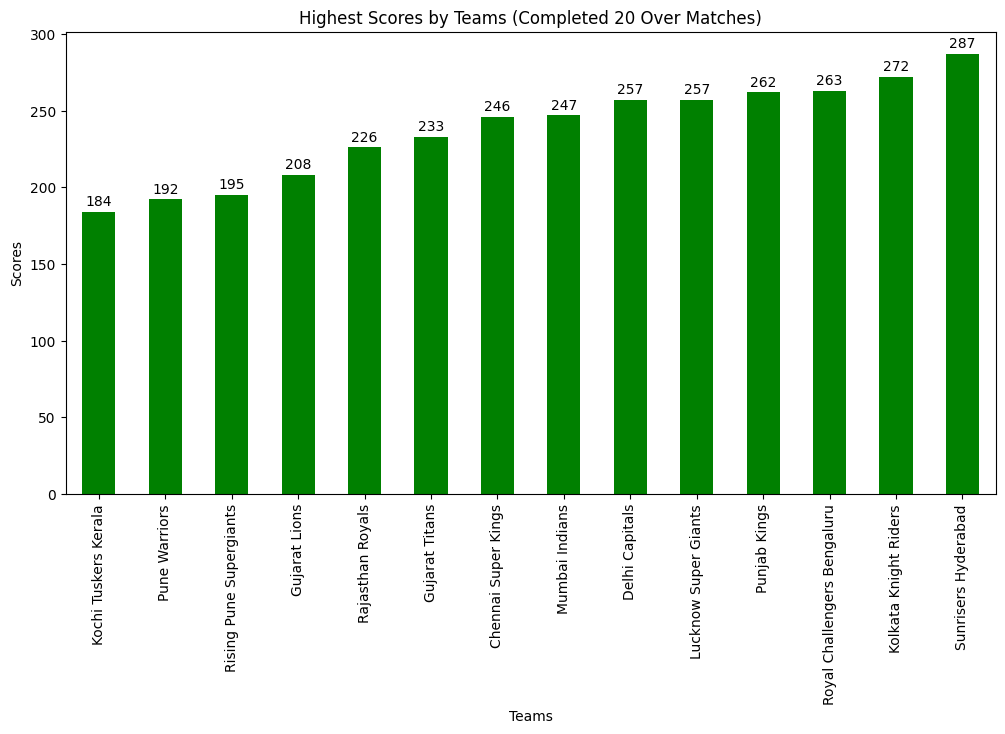

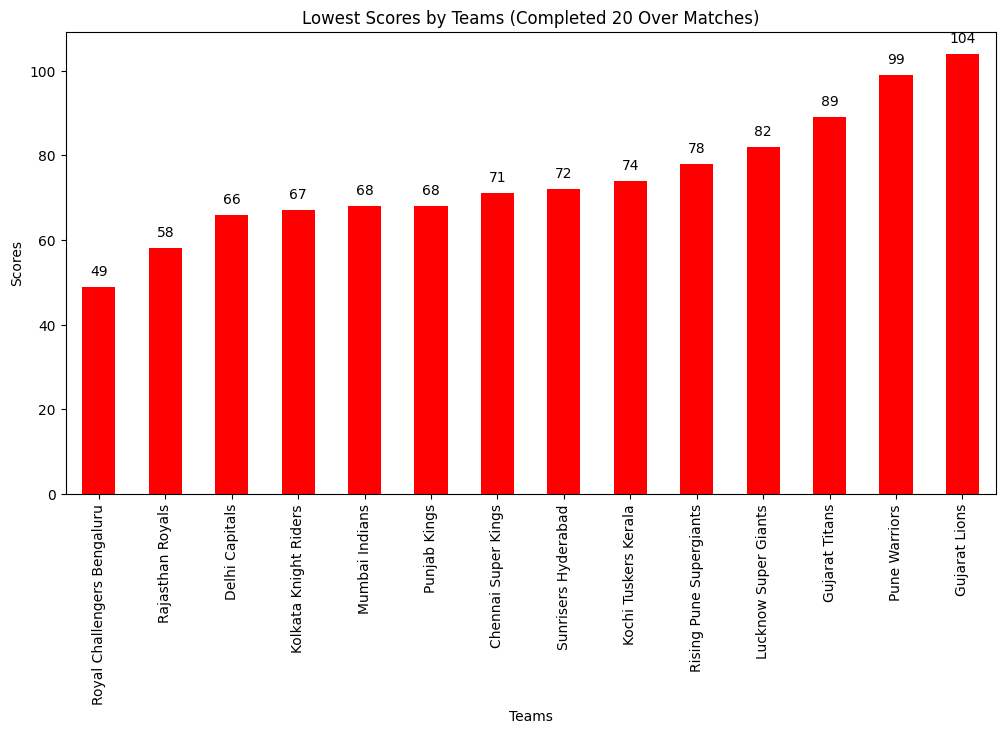

In [13]:
match_results = matches.set_index('id')['result']
target_overs = matches.set_index('id')['target_overs']

team_scores = deliveries.groupby(['match_id', 'batting_team'])['total_runs'].sum().reset_index()

team_scores['result'] = team_scores['match_id'].map(match_results)
team_scores['target_overs'] = team_scores['match_id'].map(target_overs)

valid_team_scores = team_scores[(team_scores['result'] != 'no result') & (team_scores['target_overs'] == 20)]

highest_scores = valid_team_scores.groupby('batting_team')['total_runs'].max()
lowest_scores = valid_team_scores.groupby('batting_team')['total_runs'].min()

plt.figure(figsize=(12, 6))
bars_high = highest_scores.sort_values().plot(kind='bar', color='green')
plt.xlabel("Teams")
plt.ylabel("Scores")
plt.title("Highest Scores by Teams (Completed 20 Over Matches)")
plt.xticks(rotation=90)

for bar in bars_high.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 2,
             f'{int(bar.get_height())}', ha='center', va='bottom', fontsize=10)

plt.show()

plt.figure(figsize=(12, 6))
bars_low = lowest_scores.sort_values().plot(kind='bar', color='red')
plt.xlabel("Teams")
plt.ylabel("Scores")
plt.title("Lowest Scores by Teams (Completed 20 Over Matches)")
plt.xticks(rotation=90)

for bar in bars_low.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 2,
             f'{int(bar.get_height())}', ha='center', va='bottom', fontsize=10)

plt.show()


## Total 4s and 6s by Teams

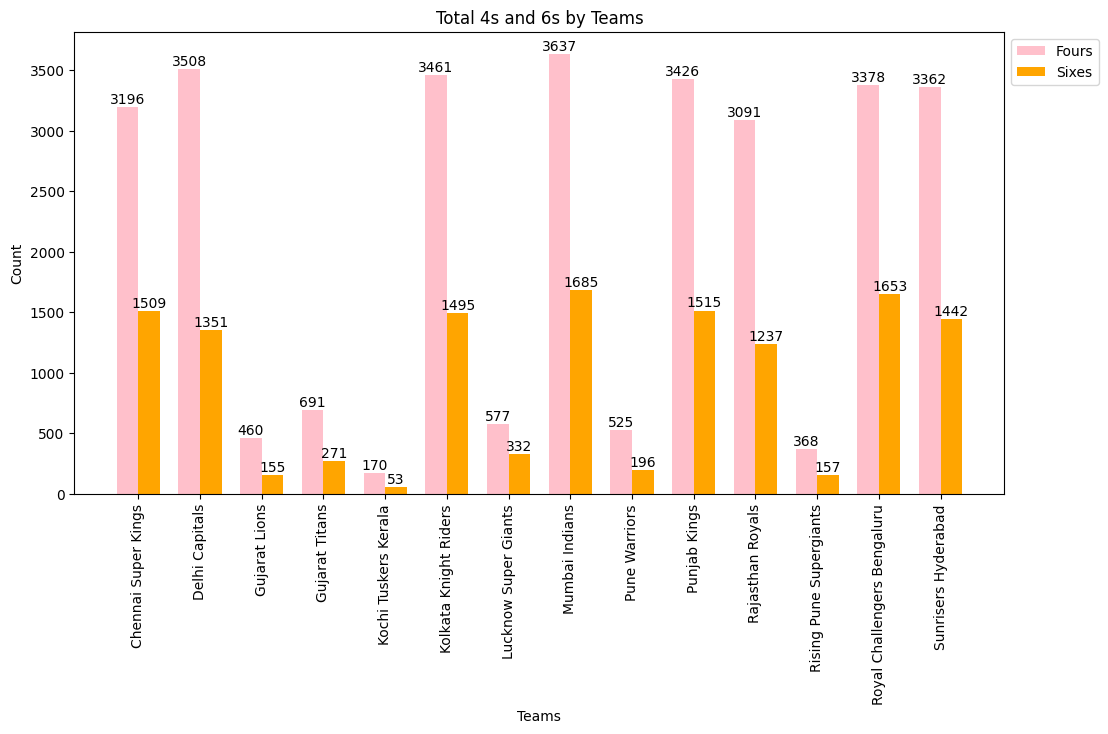

In [14]:
fours = deliveries[(deliveries['batsman_runs'] == 4)].groupby('batting_team').size()
sixes = deliveries[(deliveries['batsman_runs'] == 6)].groupby('batting_team').size()

bar_width = 0.35
teams = fours.index
x = np.arange(len(teams))

plt.figure(figsize=(12, 6))
bars_fours = plt.bar(x - bar_width / 2, fours.values, width=bar_width, color='pink', label='Fours')
bars_sixes = plt.bar(x + bar_width / 2, sixes.values, width=bar_width, color='orange', label='Sixes')

for bar in bars_fours:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5,
             f'{int(bar.get_height())}', ha='center', va='bottom', fontsize=10)

for bar in bars_sixes:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5,
             f'{int(bar.get_height())}', ha='center', va='bottom', fontsize=10)

plt.xlabel("Teams")
plt.ylabel("Count")
plt.title("Total 4s and 6s by Teams")
plt.xticks(x, teams, rotation=90)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

## Powerplay vs Death Overs Scores

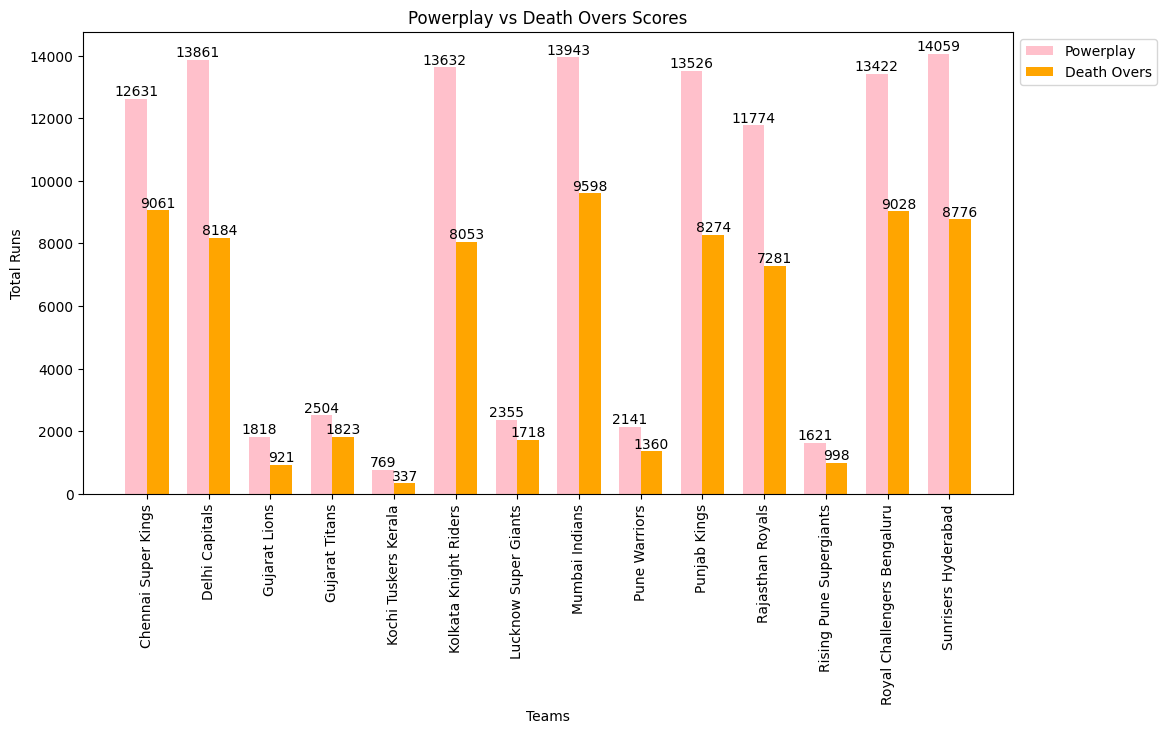

In [15]:
powerplay_scores = deliveries[(deliveries['over'] <= 6)].groupby('batting_team')['total_runs'].sum()
death_overs_scores = deliveries[(deliveries['over'] >= 16)].groupby('batting_team')['total_runs'].sum()

bar_width = 0.35
teams = powerplay_scores.index
x = np.arange(len(teams))

plt.figure(figsize=(12, 6))
bars_powerplay = plt.bar(x - bar_width / 2, powerplay_scores.values, width=bar_width, color='pink', label='Powerplay')
bars_death = plt.bar(x + bar_width / 2, death_overs_scores.values, width=bar_width, color='orange', label='Death Overs')

for bar in bars_powerplay:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5,
             f'{int(bar.get_height())}', ha='center', va='bottom', fontsize=10)

for bar in bars_death:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5,  # Adjust position
             f'{int(bar.get_height())}', ha='center', va='bottom', fontsize=10)

plt.xlabel("Teams")
plt.ylabel("Total Runs")
plt.title("Powerplay vs Death Overs Scores")
plt.xticks(x, teams, rotation=90)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [16]:
deliveries["extras_type"].unique()

array(['legbyes', 'NA', 'wides', 'byes', 'noballs', 'penalty'],
      dtype=object)

## Average Runs per Over of Teams

<ipython-input-17-9f4146097473>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_run_rate.index, y=avg_run_rate.values, palette='viridis')


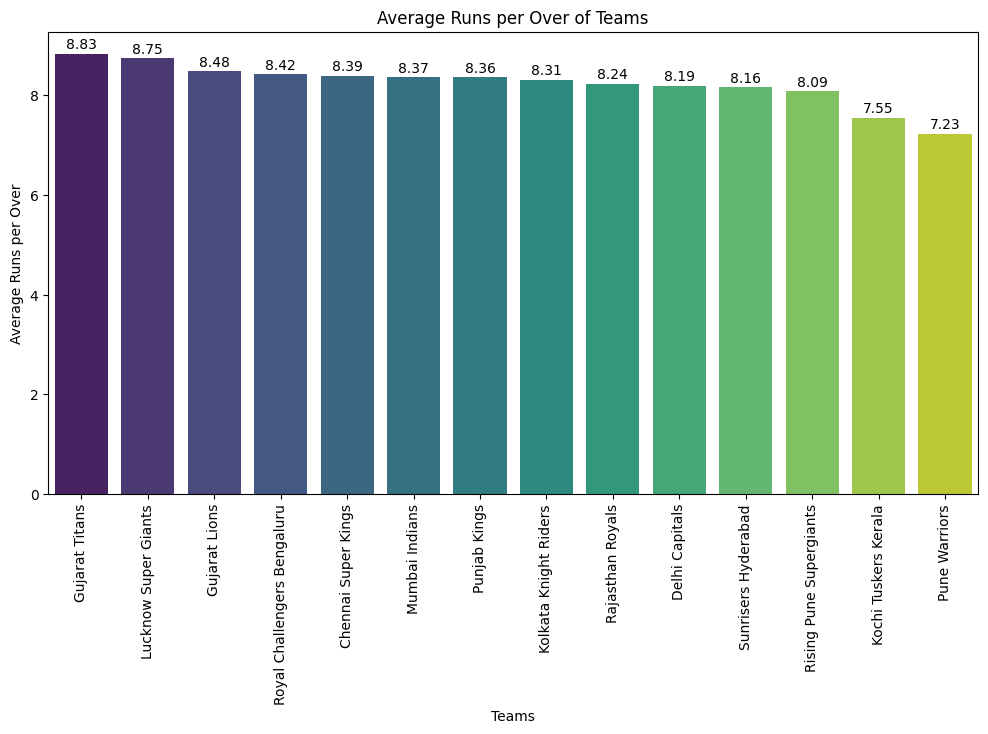

In [17]:
total_runs_scored = deliveries.groupby('batting_team')['total_runs'].sum()
valid_deliveries = deliveries[(deliveries['extras_type'] != 'wides') & (deliveries['extras_type'] != 'noballs')]  # Exclude wides from overs count
total_overs_faced = valid_deliveries.groupby('batting_team').size() / 6  # Convert balls to overs

avg_run_rate = total_runs_scored / total_overs_faced

avg_run_rate = avg_run_rate.sort_values(ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=avg_run_rate.index, y=avg_run_rate.values, palette='viridis')
plt.xticks(rotation=90)
plt.xlabel("Teams")
plt.ylabel("Average Runs per Over")
plt.title("Average Runs per Over of Teams")
for i, v in enumerate(avg_run_rate.values):
    plt.text(i, v + 0.1, f"{v:.2f}", ha='center', fontsize=10)
plt.show()

## Powerplay Performance by Teams

<ipython-input-18-18be69abd052>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=powerplay_avg.index, y=powerplay_avg.values, palette='viridis')


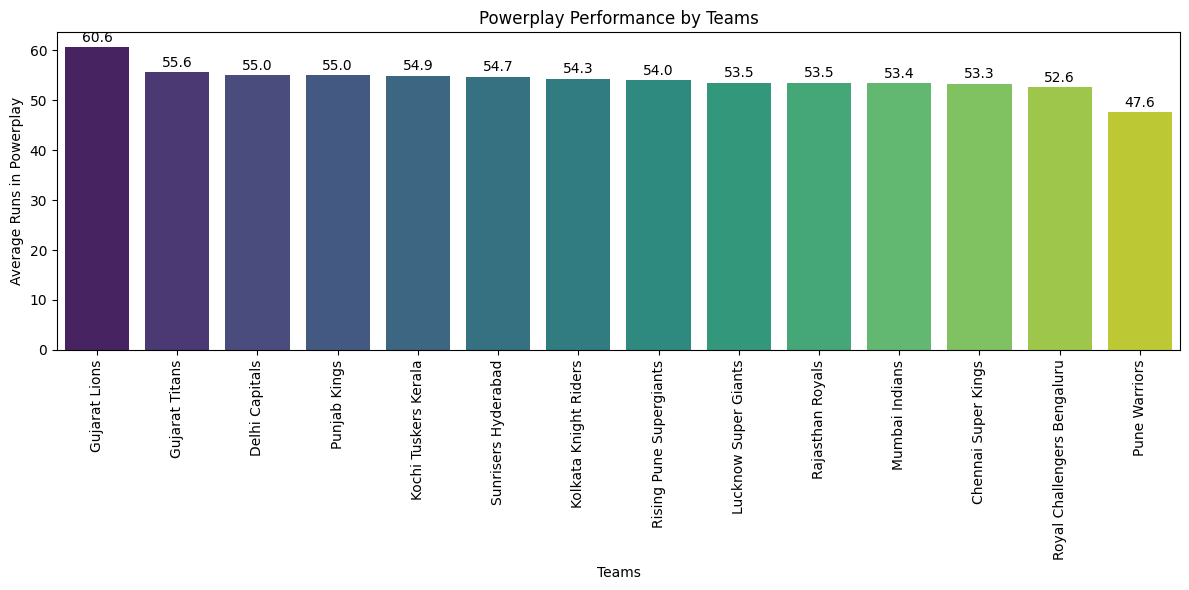

In [18]:
powerplay_runs = deliveries[deliveries['over'] <= 6].groupby(['match_id', 'batting_team'])['total_runs'].sum().reset_index()
powerplay_matches = powerplay_runs.groupby('batting_team')['match_id'].nunique()
powerplay_avg = powerplay_runs.groupby('batting_team')['total_runs'].sum() / powerplay_matches

powerplay_avg = powerplay_avg.sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=powerplay_avg.index, y=powerplay_avg.values, palette='viridis')

plt.xticks(rotation=90)
plt.xlabel("Teams")
plt.ylabel("Average Runs in Powerplay")
plt.title("Powerplay Performance by Teams")

for i, v in enumerate(powerplay_avg.values):
    plt.text(i, v + 0.5, f"{v:.1f}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Player Analysis

## Top 20 Run Scorers

<ipython-input-19-e1ccddc69fe7>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_run_scorers.index, y=top_run_scorers.values, palette='viridis')


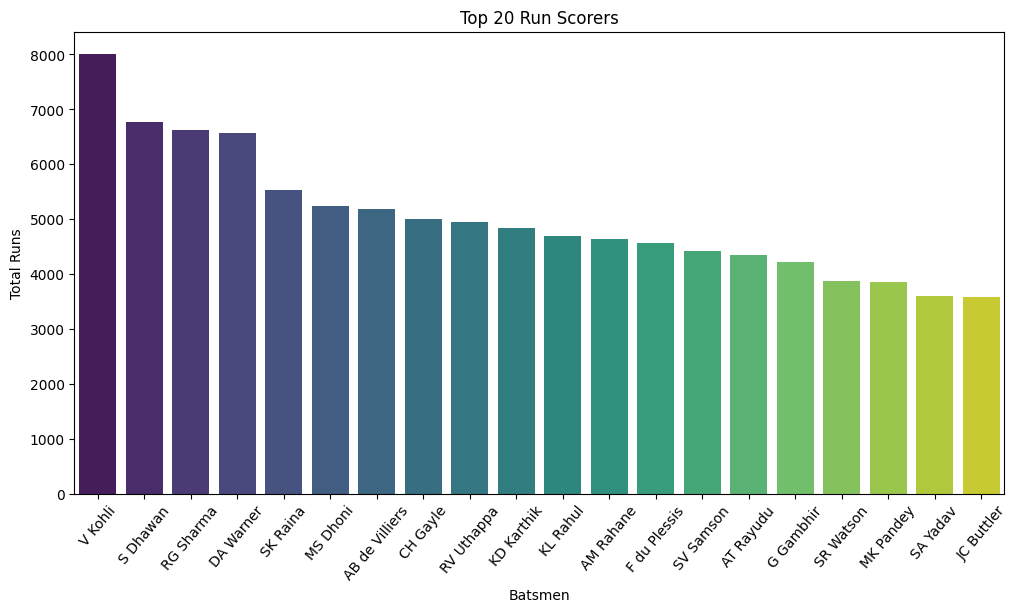

In [19]:
top_run_scorers = deliveries.groupby('batter')['batsman_runs'].sum().nlargest(20)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_run_scorers.index, y=top_run_scorers.values, palette='viridis')
plt.xticks(rotation=50)
plt.xlabel('Batsmen')
plt.ylabel('Total Runs')
plt.title('Top 20 Run Scorers')
plt.show()

## Batting Average vs Strike Rate for Top 20 Run Scorers

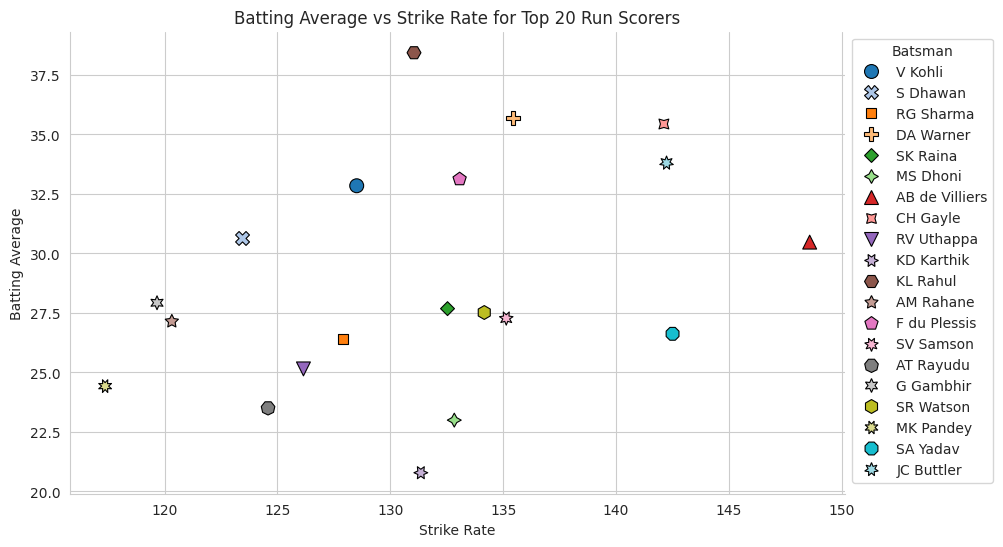

In [20]:
batting_stats = deliveries.groupby('batter').agg(
    Runs=('batsman_runs', 'sum'),
    Balls_Faced=('ball', 'count'),
    Matches=('match_id', 'nunique')
)

batting_stats = batting_stats.loc[top_run_scorers.index]


batting_stats['Strike Rate'] = (batting_stats['Runs'] / batting_stats['Balls_Faced']) * 100
batting_stats['Batting Average'] = batting_stats['Runs'] / batting_stats['Matches']


plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

scatter = sns.scatterplot(
    x=batting_stats['Strike Rate'],
    y=batting_stats['Batting Average'],
    hue=batting_stats.index,
    style=batting_stats.index,
    palette='tab20',
    s=100,
    edgecolor="black"
)

plt.xlabel('Strike Rate')
plt.ylabel('Batting Average')
plt.title('Batting Average vs Strike Rate for Top 20 Run Scorers')

plt.legend(title='Batsman', bbox_to_anchor=(1, 1), fontsize=10)
sns.despine()

plt.show()


## Top 10 Batsmen by Strike Rate and Batting Average (Min. 50 Matches)

<ipython-input-21-7e743a9f1fbc>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_batting_average.index, y=top_batting_average['Batting Average'], palette='viridis')


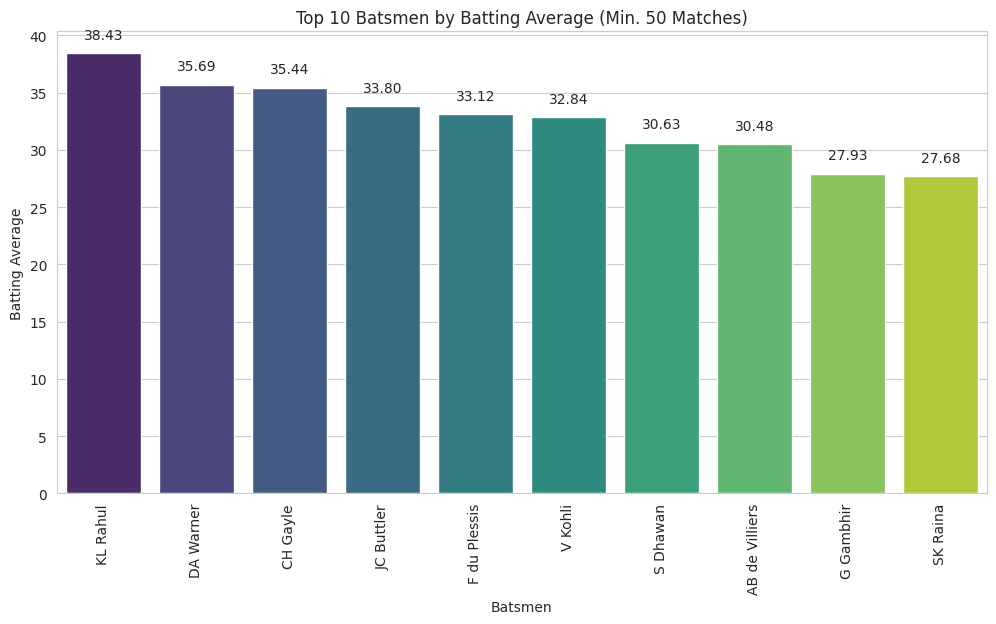

<ipython-input-21-7e743a9f1fbc>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_strike_rate.index, y=top_strike_rate['Strike Rate'], palette='viridis')


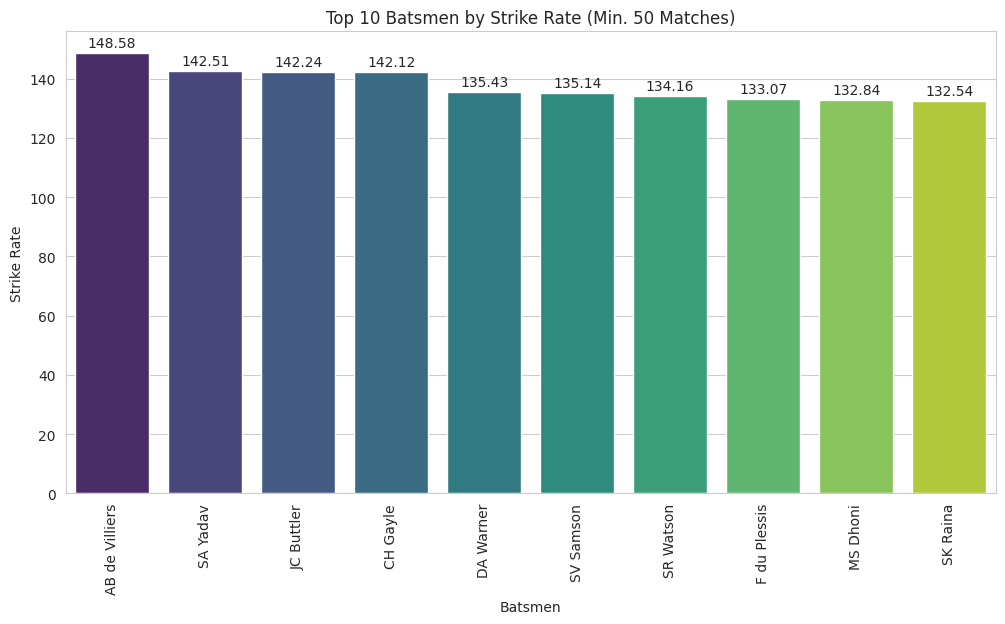

In [21]:
batting_stats['Matches'] = deliveries.groupby('batter')['match_id'].nunique()
filtered_batsmen = batting_stats[batting_stats['Matches'] > 50]
filtered_batsmen['Batting Average'] = filtered_batsmen['Runs'] / filtered_batsmen['Matches']


top_batting_average = filtered_batsmen.nlargest(10, 'Batting Average')


top_strike_rate = filtered_batsmen.nlargest(10, 'Strike Rate')



plt.figure(figsize=(12, 6))
sns.barplot(x=top_batting_average.index, y=top_batting_average['Batting Average'], palette='viridis')
plt.xticks(rotation=90)
plt.xlabel('Batsmen')
plt.ylabel('Batting Average')
plt.title('Top 10 Batsmen by Batting Average (Min. 50 Matches)')

for i, v in enumerate(top_batting_average['Batting Average'].values):
    plt.text(i, v + 1, f"{v:.2f}", ha='center', va='bottom', fontsize=10)

plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x=top_strike_rate.index, y=top_strike_rate['Strike Rate'], palette='viridis')
plt.xticks(rotation=90)
plt.xlabel('Batsmen')
plt.ylabel('Strike Rate')
plt.title('Top 10 Batsmen by Strike Rate (Min. 50 Matches)')

for i, v in enumerate(top_strike_rate['Strike Rate'].values):
    plt.text(i, v + 1, f"{v:.2f}", ha='center', va='bottom', fontsize=10)

plt.show()


## Top 10 Wicket-Takers

<ipython-input-22-b4e0311d6ca3>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_wicket_takers.index, y=top_wicket_takers["wickets"], palette="viridis")


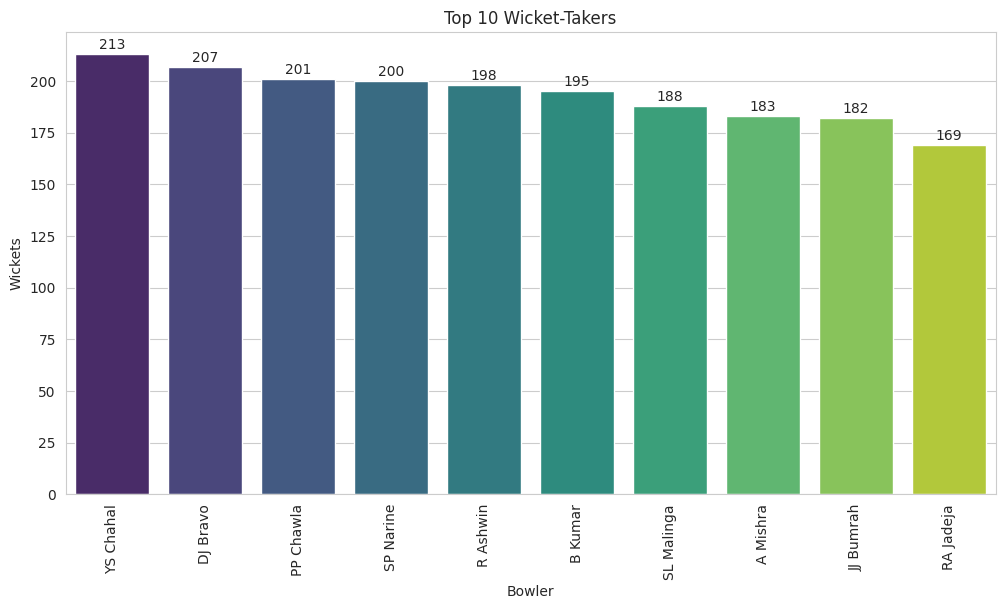

In [22]:
wicket_stats = deliveries[deliveries["is_wicket"] == 1].groupby("bowler").agg({"is_wicket": "sum"}).rename(columns={"is_wicket": "wickets"})
top_wicket_takers = wicket_stats.nlargest(10, "wickets")


plt.figure(figsize=(12, 6))
sns.barplot(x=top_wicket_takers.index, y=top_wicket_takers["wickets"], palette="viridis")
plt.xticks(rotation=90)
plt.title("Top 10 Wicket-Takers")
plt.xlabel("Bowler")
plt.ylabel("Wickets")

for i, v in enumerate(top_wicket_takers["wickets"].values):
    plt.text(i, v + 1, f"{v}", ha='center', va='bottom', fontsize=10)

plt.show()


## Top 10 Highest Individual Scores

<ipython-input-23-ff43a7611d92>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_individual_scores['batter'], y=top_individual_scores['batsman_runs'], palette='plasma', errorbar=None)


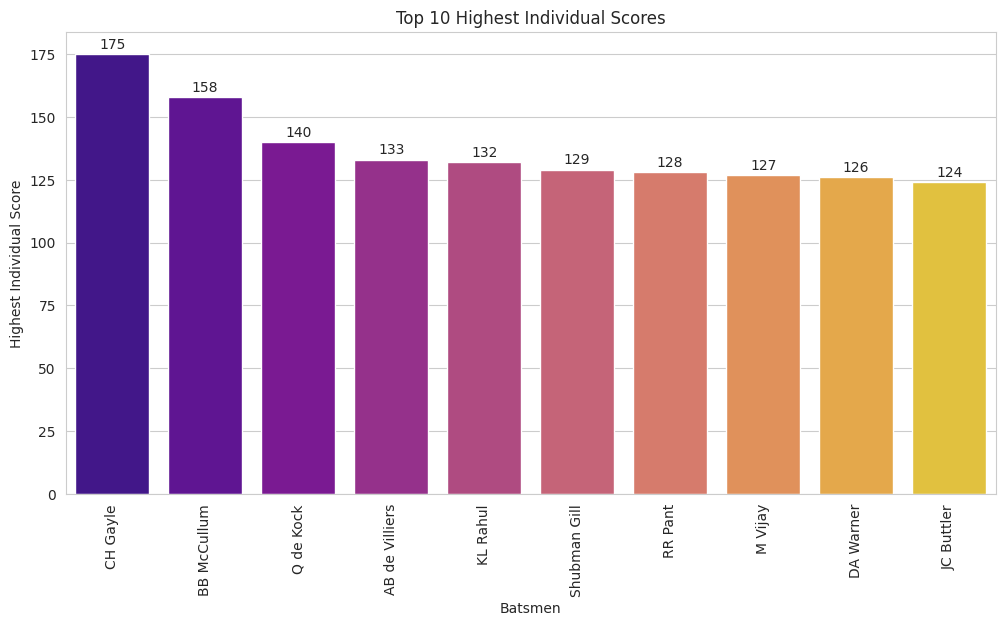

In [23]:
top_individual_scores = deliveries.groupby(['match_id', 'batter'])['batsman_runs'].sum().reset_index()

top_individual_scores = top_individual_scores.groupby('batter', as_index=False)['batsman_runs'].max()


top_individual_scores = top_individual_scores.nlargest(10, 'batsman_runs').sort_values(by='batsman_runs', ascending=False)


plt.figure(figsize=(12, 6))
sns.barplot(x=top_individual_scores['batter'], y=top_individual_scores['batsman_runs'], palette='plasma', errorbar=None)
plt.xticks(rotation=90)
plt.xlabel('Batsmen')
plt.ylabel('Highest Individual Score')
plt.title('Top 10 Highest Individual Scores')

for i, v in enumerate(top_individual_scores['batsman_runs'].values):
    plt.text(i, v + 1, f"{v}", ha='center', va='bottom', fontsize=10)

plt.show()



## Top 10 Man of the Match Winners

<ipython-input-24-5854a55ad1ee>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mom_counts.index, y=mom_counts.values, palette='plasma')


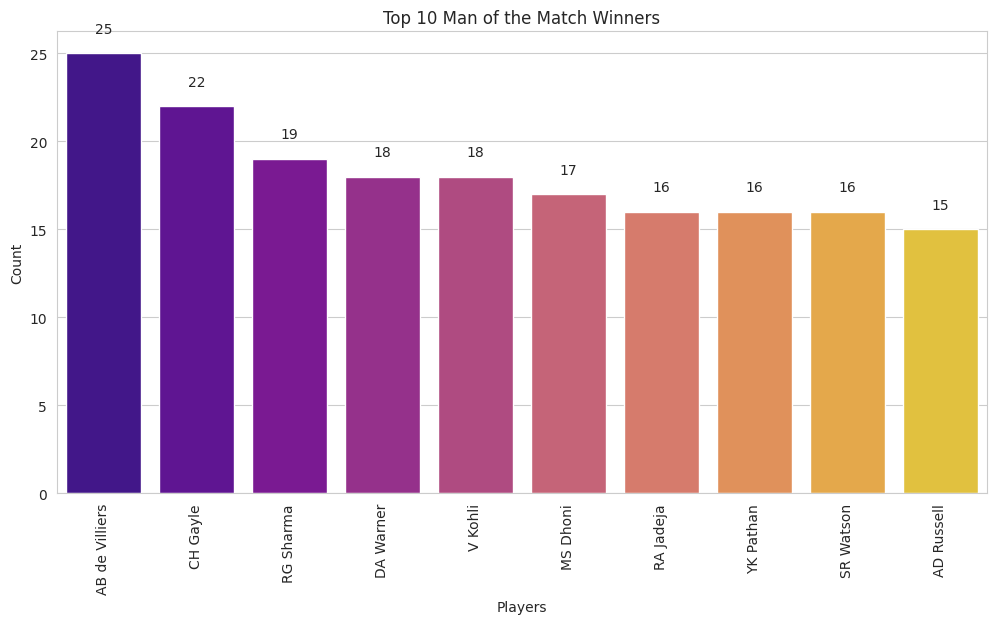

In [24]:
mom_counts = matches['player_of_match'].value_counts().nlargest(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=mom_counts.index, y=mom_counts.values, palette='plasma')
plt.xticks(rotation=90)
plt.xlabel('Players')
plt.ylabel('Count')
plt.title('Top 10 Man of the Match Winners')

for i, v in enumerate(mom_counts.values):
    plt.text(i, v + 1, f"{v}", ha='center', va='bottom', fontsize=10)

plt.show()


## K-Means Clustering of Players

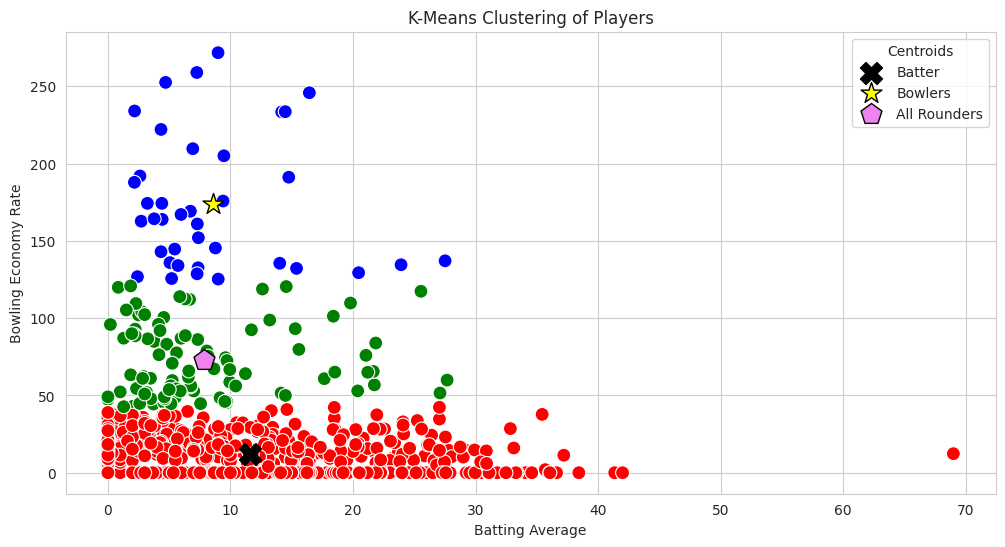

In [25]:
player_stats = deliveries.groupby('batter').agg({'batsman_runs': 'sum', 'ball': 'count'})
bowler_stats = deliveries.groupby('bowler').agg({'total_runs': 'sum', 'over': 'nunique'})
player_stats['Batting Average'] = player_stats['batsman_runs'] / deliveries.groupby('batter')['match_id'].nunique()
bowler_stats['Economy Rate'] = bowler_stats['total_runs'] / bowler_stats['over']
merged_stats = pd.merge(player_stats, bowler_stats, left_index=True, right_index=True, how='outer').fillna(0)

kmeans = KMeans(n_clusters=3, random_state=42).fit(merged_stats[['Batting Average', 'Economy Rate']])
merged_stats['Cluster'] = kmeans.labels_

centroids = kmeans.cluster_centers_

cluster_colors = ['red', 'blue', 'green']
cluster_mark_colors = ['black', 'yellow', 'violet']
centroid_markers = ['X', '*', 'p']
centroid_labels = ['Batter', 'Bowlers', 'All Rounders']


plt.figure(figsize=(12, 6))
sns.scatterplot(x=merged_stats['Batting Average'], y=merged_stats['Economy Rate'], hue=merged_stats['Cluster'], palette=cluster_colors, s=100)


centroid_handles = []
for i, (x, y) in enumerate(centroids):
    scatter = plt.scatter(x, y, c=cluster_mark_colors[i], marker=centroid_markers[i], s=250, edgecolors='black', label=centroid_labels[i])
    centroid_handles.append(scatter)

plt.xlabel('Batting Average')
plt.ylabel('Bowling Economy Rate')
plt.title('K-Means Clustering of Players')

plt.legend(handles=centroid_handles, title="Centroids", loc='upper right')

plt.show()


## Top 10 Batsmen with Most 1s, 2s, 4s and 6s

<ipython-input-26-59e2a05a6aa0>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_scorers.index, y=top_scorers.values, palette='cubehelix')


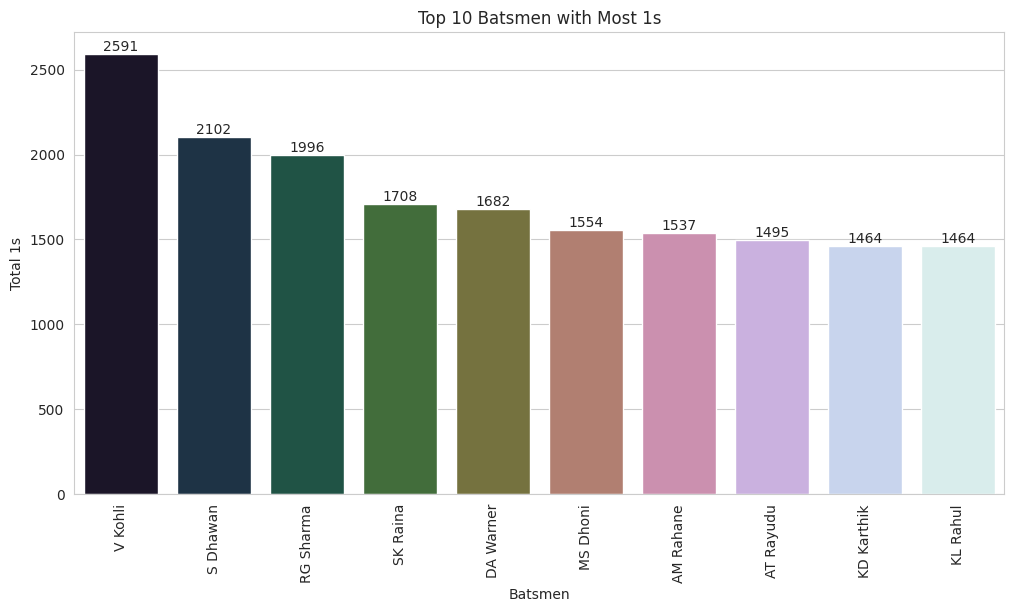

<ipython-input-26-59e2a05a6aa0>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_scorers.index, y=top_scorers.values, palette='cubehelix')


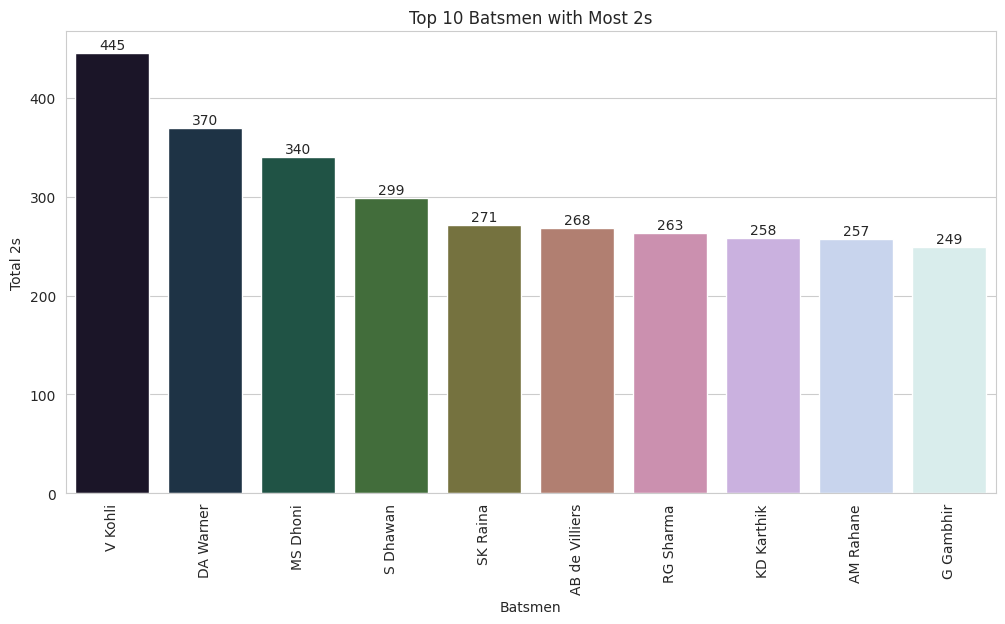

<ipython-input-26-59e2a05a6aa0>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_scorers.index, y=top_scorers.values, palette='cubehelix')


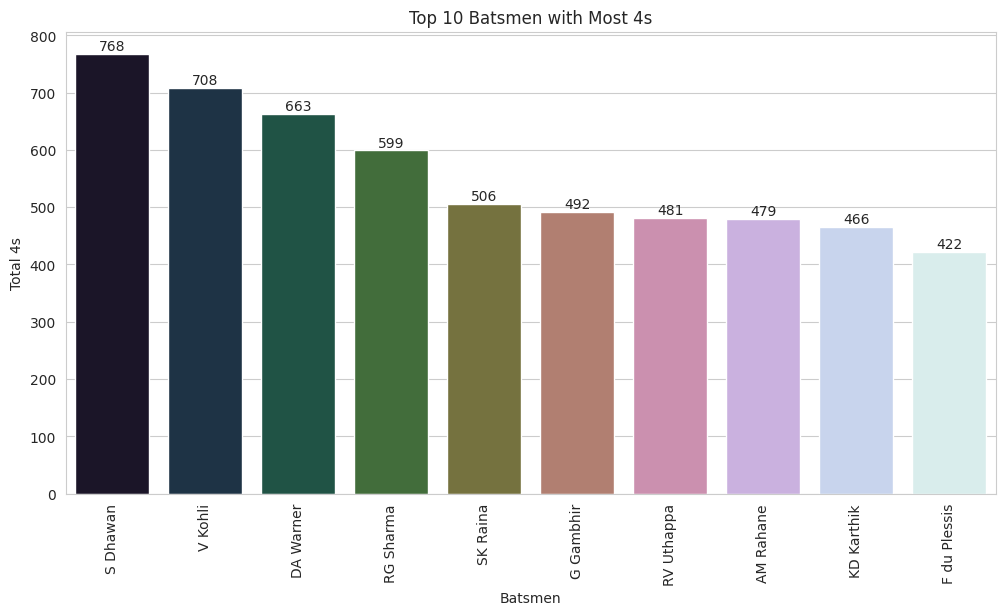

<ipython-input-26-59e2a05a6aa0>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_scorers.index, y=top_scorers.values, palette='cubehelix')


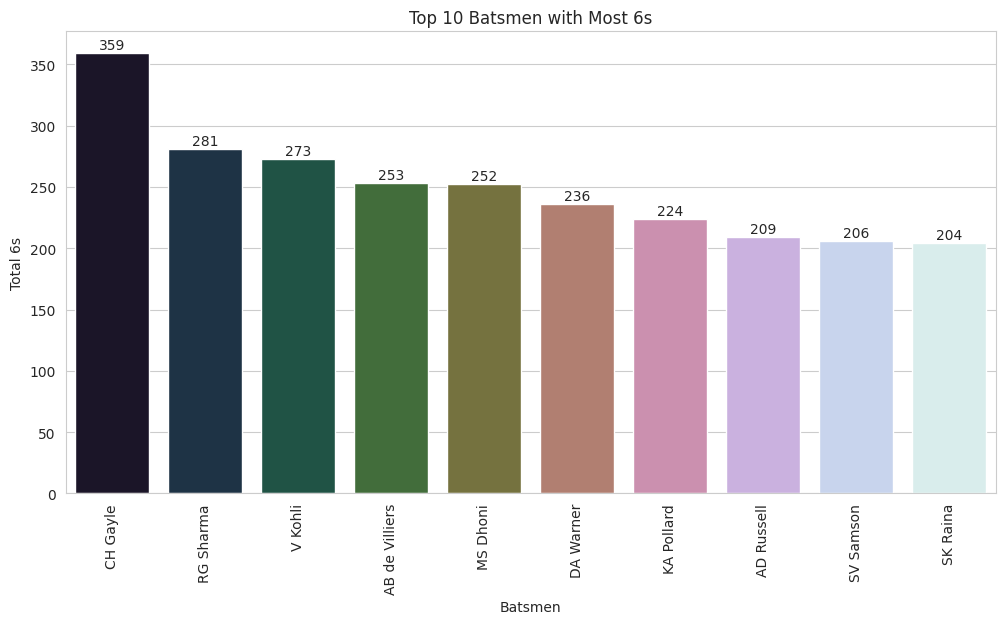

In [26]:
run_types = {1: '1s', 2: '2s', 4: '4s', 6: '6s'}
for run, label in run_types.items():
    top_scorers = deliveries[deliveries['batsman_runs'] == run].groupby('batter')['batsman_runs'].count().nlargest(10)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=top_scorers.index, y=top_scorers.values, palette='cubehelix')
    plt.xticks(rotation=90)
    plt.xlabel('Batsmen')
    plt.ylabel(f'Total {label}')
    plt.title(f'Top 10 Batsmen with Most {label}')
    for i, v in enumerate(top_scorers.values):
        plt.text(i, v + 1, f"{v}", ha='center', va='bottom', fontsize=10)
    plt.show()


# Season Analysis

## Average Runs per Match per Season

<ipython-input-27-19dee1ebfa20>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=season_avg_runs.index, y=season_avg_runs.values, palette='magma')


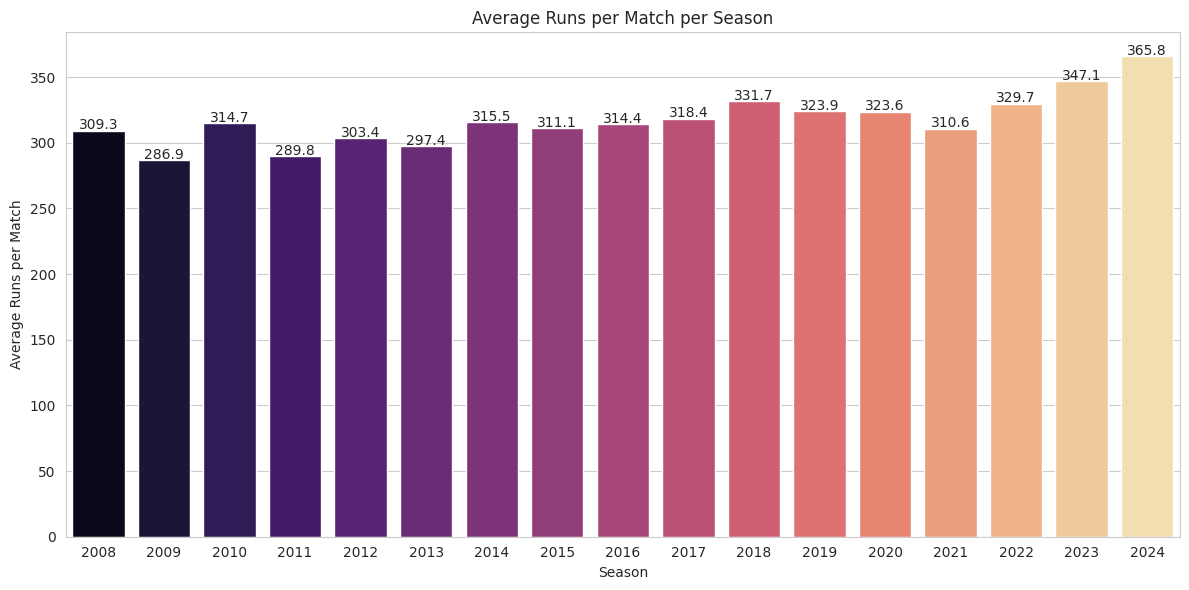

In [27]:
season_runs = deliveries.groupby('match_id')['total_runs'].sum().reset_index()

season_runs['season'] = season_runs['match_id'].map(matches.set_index('id')['season'])

season_avg_runs = season_runs.groupby('season')['total_runs'].mean()

plt.figure(figsize=(12, 6))
sns.barplot(x=season_avg_runs.index, y=season_avg_runs.values, palette='magma')

plt.xlabel("Season")
plt.ylabel("Average Runs per Match")
plt.title("Average Runs per Match per Season")

for i, v in enumerate(season_avg_runs.values):
    plt.text(i, v + 1, f"{v:.1f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()


## Number of 200+ Targets per Season

<ipython-input-28-a3eac0b35c5e>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=high_targets.index, y=high_targets.values, palette='plasma')


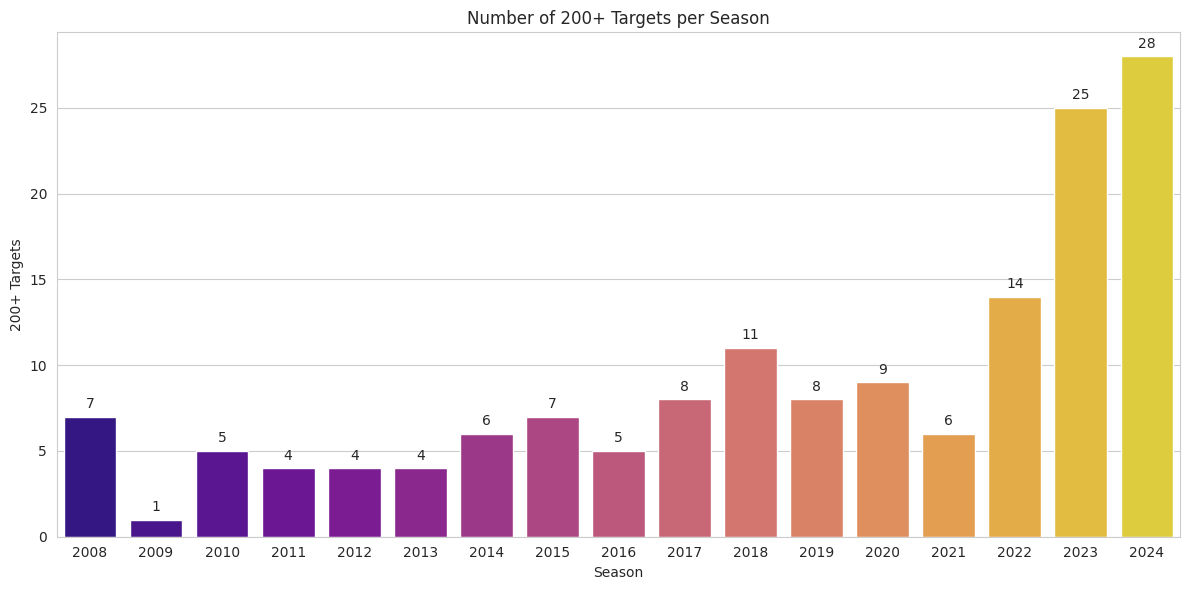

In [28]:
high_targets = matches[matches['target_runs'] >= 200].groupby('season').size()

plt.figure(figsize=(12, 6))
sns.barplot(x=high_targets.index, y=high_targets.values, palette='plasma')

plt.xlabel("Season")
plt.ylabel("200+ Targets")
plt.title("Number of 200+ Targets per Season")

for i, v in enumerate(high_targets.values):
    plt.text(i, v + 0.5, str(v), ha='center', fontsize=10)

plt.tight_layout()
plt.show()

## Average Team Scores Per Season

In [29]:
from tabulate import tabulate

team_runs = deliveries.groupby(['match_id', 'batting_team'])['total_runs'].sum().reset_index()

team_runs['season'] = team_runs['match_id'].map(matches.set_index('id')['season'])

avg_team_scores_per_season = team_runs.groupby(['batting_team', 'season'])['total_runs'].mean().reset_index()

avg_team_scores_per_season.columns = ['Team', 'Season', 'Avg_Score']

avg_team_scores_per_season['Avg_Score'] = avg_team_scores_per_season['Avg_Score'].round(2)

print(tabulate(avg_team_scores_per_season, headers='keys', tablefmt='pretty'))
avg_team_scores_per_season.to_csv('avg_team_scores_per_season.csv', index=False)


+-----+-----------------------------+--------+-----------+
|     |            Team             | Season | Avg_Score |
+-----+-----------------------------+--------+-----------+
|  0  |     Chennai Super Kings     |  2008  |   157.5   |
|  1  |     Chennai Super Kings     |  2009  |  159.36   |
|  2  |     Chennai Super Kings     |  2010  |  162.75   |
|  3  |     Chennai Super Kings     |  2011  |   160.0   |
|  4  |     Chennai Super Kings     |  2012  |  157.28   |
|  5  |     Chennai Super Kings     |  2013  |  154.33   |
|  6  |     Chennai Super Kings     |  2014  |  165.62   |
|  7  |     Chennai Super Kings     |  2015  |  160.29   |
|  8  |     Chennai Super Kings     |  2018  |  175.56   |
|  9  |     Chennai Super Kings     |  2019  |  145.47   |
| 10  |     Chennai Super Kings     |  2020  |   156.5   |
| 11  |     Chennai Super Kings     |  2021  |  170.81   |
| 12  |     Chennai Super Kings     |  2022  |  163.43   |
| 13  |     Chennai Super Kings     |  2023  |   180.8  

## Orange Cap holders of every season

In [30]:
deliveries['season'] = deliveries['match_id'].map(matches.set_index('id')['season'])

batsman_runs_per_season = deliveries.groupby(['season', 'batter'])['batsman_runs'].sum().reset_index()

orange_cap_holders = batsman_runs_per_season.loc[batsman_runs_per_season.groupby('season')['batsman_runs'].idxmax()]

orange_cap_holders.columns = ['Season', 'Batter', 'Total_Runs']

orange_cap_holders['Total_Runs'] = orange_cap_holders['Total_Runs'].astype(int)

print(tabulate(orange_cap_holders, headers='keys', tablefmt='pretty', showindex=False))

orange_cap_holders.to_csv('orange_cap_holders.csv', index=False)


+--------+---------------+------------+
| Season |    Batter     | Total_Runs |
+--------+---------------+------------+
|  2008  |   SE Marsh    |    616     |
|  2009  |   ML Hayden   |    572     |
|  2010  | SR Tendulkar  |    618     |
|  2011  |   CH Gayle    |    608     |
|  2012  |   CH Gayle    |    733     |
|  2013  |  MEK Hussey   |    733     |
|  2014  |  RV Uthappa   |    660     |
|  2015  |   DA Warner   |    562     |
|  2016  |    V Kohli    |    973     |
|  2017  |   DA Warner   |    641     |
|  2018  | KS Williamson |    735     |
|  2019  |   DA Warner   |    692     |
|  2020  |   KL Rahul    |    676     |
|  2021  |  RD Gaikwad   |    635     |
|  2022  |  JC Buttler   |    863     |
|  2023  | Shubman Gill  |    890     |
|  2024  |    V Kohli    |    741     |
+--------+---------------+------------+


## Purple Cap holders of every season

In [31]:
deliveries['season'] = deliveries['match_id'].map(matches.set_index('id')['season'])

wicket_deliveries = deliveries[deliveries['is_wicket'] == 1]

bowler_wickets_per_season = wicket_deliveries.groupby(['season', 'bowler']).size().reset_index(name='wickets')

purple_cap_holders = bowler_wickets_per_season.loc[bowler_wickets_per_season.groupby('season')['wickets'].idxmax()]

purple_cap_holders.columns = ['Season', 'Bowler', 'Total_Wickets']

purple_cap_holders['Total_Wickets'] = purple_cap_holders['Total_Wickets'].astype(int)

print(tabulate(purple_cap_holders, headers='keys', tablefmt='pretty', showindex=False))

purple_cap_holders.to_csv('purple_cap_holders.csv', index=False)


+--------+---------------+---------------+
| Season |    Bowler     | Total_Wickets |
+--------+---------------+---------------+
|  2008  | Sohail Tanvir |      24       |
|  2009  |   RP Singh    |      26       |
|  2010  |    PP Ojha    |      22       |
|  2011  |  SL Malinga   |      30       |
|  2012  |   M Morkel    |      30       |
|  2013  |   DJ Bravo    |      34       |
|  2014  |   MM Sharma   |      26       |
|  2015  |   DJ Bravo    |      28       |
|  2016  |    B Kumar    |      24       |
|  2017  |    B Kumar    |      28       |
|  2018  |    AJ Tye     |      28       |
|  2019  |   K Rabada    |      29       |
|  2020  |   K Rabada    |      32       |
|  2021  |   HV Patel    |      35       |
|  2022  |   YS Chahal   |      29       |
|  2023  |   MM Sharma   |      31       |
|  2024  |   HV Patel    |      30       |
+--------+---------------+---------------+


## Top 10 Bowlers per Season

In [32]:
deliveries['season'] = deliveries['match_id'].map(matches.set_index('id')['season'])

wicket_deliveries = deliveries[deliveries['is_wicket'] == 1]

bowler_wickets_per_season = wicket_deliveries.groupby(['season', 'bowler']).size().reset_index(name='wickets')

bowler_wickets_per_season = bowler_wickets_per_season.sort_values(['season', 'wickets'], ascending=[True, False])

top_10_bowlers_per_season = bowler_wickets_per_season.groupby('season').head(10).reset_index(drop=True)

top_10_bowlers_per_season['wickets'] = top_10_bowlers_per_season['wickets'].astype(int)

print(tabulate(top_10_bowlers_per_season, headers='keys', tablefmt='pretty', showindex=False))

top_10_bowlers_per_season.to_csv('top_10_bowlers_per_season.csv', index=False)


+--------+-------------------+---------+
| season |      bowler       | wickets |
+--------+-------------------+---------+
|  2008  |   Sohail Tanvir   |   24    |
|  2008  |     IK Pathan     |   20    |
|  2008  |     JA Morkel     |   20    |
|  2008  |     SK Warne      |   20    |
|  2008  |     SR Watson     |   20    |
|  2008  |    MF Maharoof    |   19    |
|  2008  |     PP Chawla     |   19    |
|  2008  |    S Sreesanth    |   19    |
|  2008  |      MS Gony      |   18    |
|  2008  |     RP Singh      |   17    |
|  2009  |     RP Singh      |   26    |
|  2009  |     A Kumble      |   22    |
|  2009  |      A Nehra      |   22    |
|  2009  |      PP Ojha      |   21    |
|  2009  |    SL Malinga     |   21    |
|  2009  |     DP Nannes     |   20    |
|  2009  |     IK Pathan     |   20    |
|  2009  |     MM Patel      |   18    |
|  2009  |    PJ Sangwan     |   18    |
|  2009  |  M Muralitharan   |   16    |
|  2010  |      PP Ojha      |   22    |
|  2010  |     A